## Izuogu Chibuzor Godson

## Outline

- Importing Libraries
- Loading Data
- Data Visualization
- Data Pre-processing
- Modelling
- Model Evaluation
- Saving the Model

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import seaborn as sns; sns.set()

import os
import warnings
warnings.filterwarnings("ignore") #For a neat notebook
from IPython.display import Image
%matplotlib inline

## Loading Data

In [2]:
#defining Image tensor
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
#loading the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    seed=42,
    #label_mode="categorical",
    
)

Found 300 files belonging to 3 classes.
Using 270 files for training.


In [4]:
#loading the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    seed=42,
    #label_mode="categorical",
    
)

Found 300 files belonging to 3 classes.
Using 30 files for validation.


In [5]:
class_names = train_ds.class_names #Each folder name represent a class name
n_classes = len(class_names)
print(f'There are {n_classes} classes, and they are: {class_names}')

There are 3 classes, and they are: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## Data Visualizations

32
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


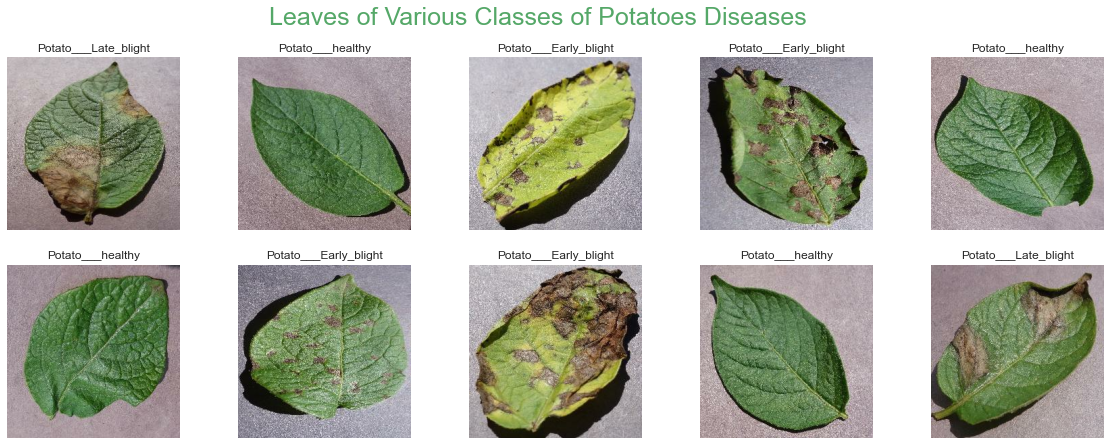

In [7]:
plt.figure(figsize=(20,7))
for image_batch, label_batch in train_ds.take(1):
    print(len(label_batch))
    
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        print(image_batch.shape)
        #print(label_batch.numpy())
        #print(image_batch[0].numpy())

        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.suptitle("Leaves of Various Classes of Potatoes Diseases", fontsize=25, color="g")
        plt.axis("off")
        #plt.savefig("Tomatoe Leaves 4")

## Data Preprocessing

In [8]:
# Data Shuffling
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
#Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/256)
    
])

In [10]:
# Data Anotation
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
    
])

## Modelling

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from glob import glob
# make predictions using a pretrained model
from keras.applications.efficientnet import EfficientNetB6
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.preprocessing import image

In [15]:
model = Sequential()

base_model = EfficientNetB6(weights='imagenet',
                            include_top=False,
                            input_shape=(256,256,3))

# freeze extraction layers
base_model.trainable = False

In [ ]:
# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dense(3, activation="softmax"))

In [17]:
# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 8, 8, 2304)       40960143  
                                                                 
 global_average_pooling2d_1   (None, 2304)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1180160   
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 42,141,842
Trainable params: 1,181,699
Non-trainable params: 40,960,143
__________________________________

In [19]:
# create callback to use during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights.h5',
                                                save_best_only=True,
                                                save_weights_only=True)

# compile the model
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/5
9/9 [==============================] - 684s 62s/step - loss: 0.7949 - accuracy: 0.6148 - val_loss: 0.2519 - val_accuracy: 0.9333
Epoch 2/5
9/9 [==============================] - 471s 53s/step - loss: 0.3276 - accuracy: 0.8704 - val_loss: 0.3312 - val_accuracy: 0.8333
Epoch 3/5
9/9 [==============================] - 495s 56s/step - loss: 0.2733 - accuracy: 0.8889 - val_loss: 0.2451 - val_accuracy: 0.9333
Epoch 4/5
9/9 [==============================] - 482s 54s/step - loss: 0.1924 - accuracy: 0.9259 - val_loss: 0.2075 - val_accuracy: 0.9667
Epoch 5/5
9/9 [==============================] - 492s 55s/step - loss: 0.1246 - accuracy: 0.9556 - val_loss: 0.1279 - val_accuracy: 0.9667


In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    base_model
])
model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.5))
    
model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.5))
    
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 8, 8, 2304)       40960143  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 32)          663584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3, 3, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 512)         147968    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 512)        0         
 2D)                                                  

## Model Evaluation

In [ ]:
from sklearn.metrics import GridSearchCV, Classification_report

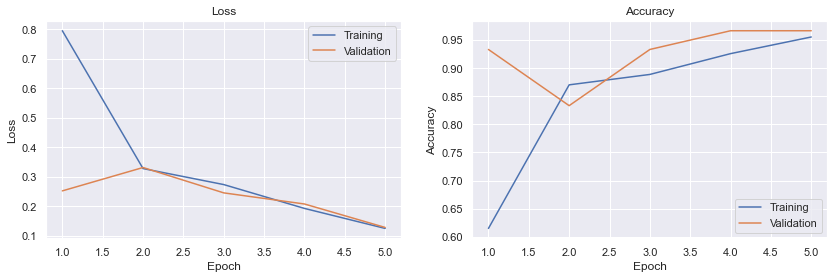

In [21]:
# save results
results = history.history

# plot results
n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## saving The Model

In [20]:
# uncomment the line below to save the model
model.save('potato_model.h5')

## Prediction Pipeline

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class Preprocessor(BaseEstimator, TransformerMixin):
    def fit(self,img_object):
        return self
    
    def transform(self,img_object):
        img_array = image.img_to_array(img_object)
        expanded = (np.expand_dims(img_array,axis=0))
        return expanded

class Predictor(BaseEstimator, TransformerMixin):
    def fit(self,img_array):
        return self
    
    def predict(self,img_array):
        probabilities = model.predict(img_array)
        predicted_class = test_ds.class_names[probabilities.argmax()]
        return predicted_class

full_pipeline = Pipeline([('preprocessor',Preprocessor()),
                         ('predictor',Predictor())])